In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df_2023= pd.read_csv('data/2023/외래관광객조사_2023_전처리.csv')
df_2024= pd.read_csv('data/2024/외래관광객조사_2024_전처리.csv')

In [5]:
# 23, 24년도 데이터 병합
df_all = pd.concat([df_2023, df_2024], ignore_index=True)

In [6]:
# 병합된 데이터 확인
print(df_all.shape)
print(df_all['year'].value_counts())  # 연도별 분포 확인

(16502, 23)
year
2024    8442
2023    8060
Name: count, dtype: int64


### 동행자유형별 표본 수 확인

In [7]:
df_all['동행자유형'].value_counts(dropna=False)

동행자유형
가족      6848
친구      5197
혼자      3724
직장동료     693
기타        40
Name: count, dtype: int64

### 여가체험비율 분포 시각화

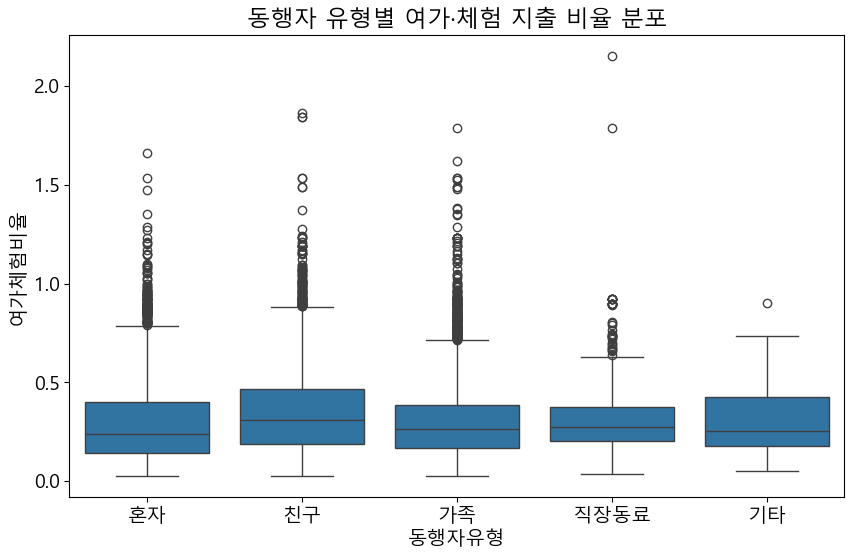

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='동행자유형', y='여가체험비율')
plt.title("동행자 유형별 여가·체험 지출 비율 분포")
plt.ylabel("여가체험비율")
plt.xlabel("동행자유형")
plt.show()

In [12]:
df_all.groupby('동행자유형')['여가체험비율'].median().sort_values(ascending=False)

동행자유형
친구      0.311236
직장동료    0.271574
가족      0.264108
기타      0.253169
혼자      0.240205
Name: 여가체험비율, dtype: float64

- 친구 그룹이 여가·체험 비중이 가장 높음
- 가족그룹 보다 직장동료 그룹의 여가체험비율이 높은건 표본 수 불균형 때문일 가능성도 있음
- 추후 유의성 검정 (ANOVA) 및 사후검정으로 통계적으로 유의한 차이인지 확인해야함

### 평균 비교 및 유의성 검정 (ANOVA)

In [14]:
# '기타' 그룹 제외
df_filtered = df_all[df_all['동행자유형'] != '기타']

# 그룹별 여가체험비율 리스트 생성
groups = [g['여가체험비율'].dropna() for _, g in df_filtered.groupby('동행자유형')]

# 일원분산분석 수행
anova_result = f_oneway(*groups)
print(anova_result)

F_onewayResult(statistic=58.55028572343505, pvalue=1.2146034487859254e-37)


- ANOVA 결과
- F통계량 = 58.55 (매우 큼)
- p < 1e-37 (극히 유의함)

- 동행자 유형에 따라 여가체험 지출 비율 평균이 매우 분명하게 차이 난다

### ‘직장동료’ 제외 후 재분석

In [15]:
df_main = df_all[df_all['동행자유형'].isin(['혼자', '가족', '친구'])].copy()

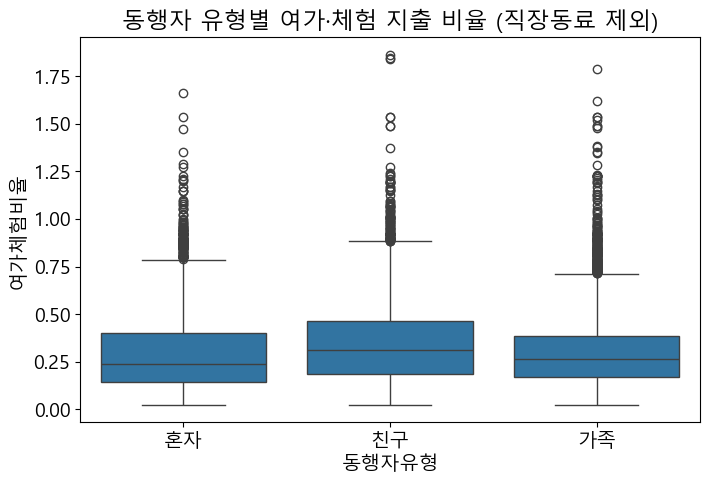

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_main, x='동행자유형', y='여가체험비율')
plt.title("동행자 유형별 여가·체험 지출 비율 (직장동료 제외)")
plt.show()


In [18]:
df_main.groupby('동행자유형')['여가체험비율'].median().sort_values(ascending=False)


동행자유형
친구    0.311236
가족    0.264108
혼자    0.240205
Name: 여가체험비율, dtype: float64

In [19]:
from scipy.stats import f_oneway

groups_main = [g['여가체험비율'].dropna() for _, g in df_main.groupby('동행자유형')]
anova_main = f_oneway(*groups_main)
print(anova_main)


F_onewayResult(statistic=86.51258060544707, pvalue=4.292749652931614e-38)


#### 직장동료 제거 후
- 남은 세 그룹 간의 분산 차이가 상대적으로 더 명확해졌음

- ‘직장동료’는 그 자체로 중간값이 높고, 분포가 좁아 전체 분산을 줄이는 역할을 했을 가능성 있음
- 통계적 유의성이 강화되고 정책적, 실무적 해석도 더 명확해짐

In [23]:
# 등분산성 검정
levene_result = levene(*groups_main)
print(levene_result)

LeveneResult(statistic=46.755590428583446, pvalue=5.67919151042771e-21)


- pvalue < 0.05 
- ANOVA 검정의 전제 깨짐

In [24]:
# 효과 크기 계산 (Eta Squared, η²)
# Eta squared (η²)
def eta_squared(f_stat, df_between, df_within):
    return (f_stat * df_between) / (f_stat * df_between + df_within)

# df_between = 그룹 수 - 1 = 2, df_within = 전체 표본 수 - 그룹 수
n_total = df_main.shape[0]
eta2 = eta_squared(anova_main.statistic, df_between=2, df_within=n_total - 3)
print(f"Effect size (η²): {eta2:.4f}")


Effect size (η²): 0.0109


- η² < 0.01 => 매우 작은 효과
- 0.01~0.06 => 작은효과
- η² > 0.14 => 큰 효과
- 통계적으로는 유의미했지만, 실제 효과 크기는 작음.

- 동행자 유형이 여가체험비율에 미치는 영향은 존재하되, 크지는 않다.

In [25]:
# 사후검정 (Tukey HSD)
tukey = pairwise_tukeyhsd(endog=df_main['여가체험비율'],
                          groups=df_main['동행자유형'],
                          alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    가족     친구   0.0444    0.0  0.0355  0.0533   True
    가족     혼자  -0.0044 0.5541 -0.0142  0.0055  False
    친구     혼자  -0.0487    0.0 -0.0591 -0.0383   True
----------------------------------------------------


In [26]:
# 직장동료 그룹 포함 유무에 따른 ANOVA 검정 비교

# 포함: 혼자, 가족, 친구, 직장동료
df_all_4 = df_all[df_all['동행자유형'].isin(['혼자', '가족', '친구', '직장동료'])].copy()
groups_4 = [g['여가체험비율'].dropna() for _, g in df_all_4.groupby('동행자유형')]
anova_4 = f_oneway(*groups_4)

# 제외: 혼자, 가족, 친구만
df_main = df_all[df_all['동행자유형'].isin(['혼자', '가족', '친구'])].copy()
groups_3 = [g['여가체험비율'].dropna() for _, g in df_main.groupby('동행자유형')]
anova_3 = f_oneway(*groups_3)

# 비교 출력
print(f"포함 F: {anova_4.statistic:.3f}, p: {anova_4.pvalue:.2e}")
print(f"제외 F: {anova_3.statistic:.3f}, p: {anova_3.pvalue:.2e}")


포함 F: 58.550, p: 1.21e-37
제외 F: 86.513, p: 4.29e-38


- 친구/가족 그룹에 비해 표본 수가 7~8배 적음 -> 표본 불균형/통계 왜곡 가능성
- F값이 오히려 더 커짐 -> 그룹 간 차이가 더 또렷해짐

### Welch ANOVA로 재분석 

In [28]:
welch_result = pg.welch_anova(dv='여가체험비율', between='동행자유형', data=df_main)
print(welch_result)

  Source  ddof1        ddof2          F         p-unc       np2
0  동행자유형      2  8905.270041  82.929027  2.068542e-36  0.010855


- F통계량: 82.93 ->그룹 간 평균 차이가 큼
- p-unc: 2.07e-36 (p < 0.001) → 통계적으로 유의미한 차이 존재
- 효과 크기 : np2 (η²)	0.0109 → 작은 효과 / 통계적으론 유의미하나 실제 영향력은 크지 않음

### Games-Howell 사후검정
- 등분산성 없을 때 적합한 방법

In [29]:
pg.pairwise_gameshowell(dv='여가체험비율', between='동행자유형', data=df_main)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,가족,친구,0.306019,0.350384,-0.044366,0.003784,-11.722999,10584.309049,0.000000,-0.218529
1,가족,혼자,0.306019,0.301660,0.004359,0.004273,1.020007,6932.091643,0.564216,0.021481
2,친구,혼자,0.350384,0.301660,0.048724,0.004644,10.492949,7932.944764,0.000000,0.225932


- 가족 vs 친구
- 친구 > 가족: 친구그룹의 여가체험비율이 유의하게 더 높음 

- 가족 vs 혼자
- 통계적으로 유의미한 차이 없음

- 친구 vs 혼자
- 친구 > 혼자: 친구그룹의 여가체험비 지출 비율이 유의하게 더 높음

- 친구와 함께 여행 온 외국인 관광객은 혼자나 가족과 온 경우보다 여가·체험 활동에 유의미하게 더 많이 지출하는 경향이 있음
- 혼자 vs 가족은 차이가 거의 없으므로, 두 그룹의 여가소비는 유사한 행동 패턴을 보이는 그룹이라 볼 수 있음

-  여가·체험비율은 동행자 유형에 따라 유의미한 차이가 있으며,
- 특히 친구와 함께 온 관광객은 혼자 또는 가족 단위보다 더 적극적으로 여가체험 활동에 지출하는 경향이 있음